## Importing Packages

In [118]:
import gym
import math
import numpy as np
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

## Redefining the Environment

In [119]:
from gym.envs import box2d

In [120]:
FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

In [121]:
class RewardShaped(box2d.lunar_lander.LunarLander):
    def __init__(self, **kwargs):
        super(RewardShaped, self).__init__(**kwargs)
        
    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = math.tanh(
                math.sin(0.02 * self.torque_idx)
                + (math.sin(math.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2),
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            1.0 if self.legs[0].ground_contact else 0.0,
            1.0 if self.legs[1].ground_contact else 0.0,
        ]
        assert len(state) == 8

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[4])
            - 1 * abs(state[3])/5
            - 20 * abs(state[5])
            + 30 * state[6]
            + 30 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= (
            m_power * 0.2
        )  # less fuel spent is better, about -30 for heuristic landing
        reward -= s_power * 0.02

        Chunks = 11
        Wi = VIEWPORT_W / SCALE
        chunkx = [Wi / (Chunks - 1) * i for i in range(Chunks)]
        helipadx1 = chunkx[Chunks // 2 - 1]
        helipadx2 = chunkx[Chunks // 2 + 1]
        left_pad = (helipadx1 - 10) / 10
        right_pad = (helipadx2 - 10) / 10


        terminated = False
        if self.game_over or abs(state[0]) >= 1.0:
            terminated = True
            reward = -100
        if state[6] == 1 and state[7] == 1 and not self.game_over and state[0] > left_pad and state[0] < right_pad:
            self.lander.awake = False
        if not self.lander.awake:
            terminated = True
            reward = +150

        if self.render_mode == "human":
            self.render()
        return np.array(state, dtype=np.float32), reward, terminated, False, {}

## Registering the new environment

In [122]:
from gym.envs.registration import register

In [123]:
register(
    id='Lon', # name given to this new environment
    entry_point=__name__+':RewardShaped', # env entry point
    kwargs={}
)

In [124]:
from gym import envs
print(envs.registry["Lon"])

EnvSpec(id='Lon', entry_point='__main__:RewardShaped', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='Lon', version=None)


In [125]:
env = gym.make("Lon")

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

In [127]:
import pennylane as qml

## Defining Actor VQC Function

In [128]:
def ActorLayer(n_qubits, n_layers):

    # For Pennylane simulator
    #dev = qml.device("default.qubit", wires=n_qubits)

    # For IBMQ simulator
    dev = qml.device("qiskit.ibmq", wires=n_qubits, backend="ibmq_qasm_simulator", ibmqx_token="<enter IBM token>")

    dimensions = {
        "x_weights": (n_layers, n_qubits),
        #"y_weights": (n_layers, n_qubits),
        "z_weights": (n_layers, n_qubits)
    }

    @qml.qnode(dev, interface='torch')
    def circuit(inputs, x_weights, z_weights):
        for layer_idx in range(n_layers):
            if (layer_idx == 0):
                for wire in range(n_qubits):
                    qml.RX(inputs[wire], wires=wire)
            for wire, x_weight in enumerate(x_weights[layer_idx]):
                qml.RX(x_weight, wires=wire)
            #for wire, y_weight in enumerate(y_weights[layer_idx]):
            #    qml.RX(y_weight, wires=wire)
            for wire, z_weight in enumerate(z_weights[layer_idx]):
                qml.RZ(z_weight, wires=wire)
            for wire in range(n_qubits-1):
                qml.CNOT(wires=[wire, (wire + 1) % n_qubits])
        return [
            qml.expval(qml.PauliZ(6) @ qml.PauliZ(7)),
            qml.expval(qml.PauliZ(0) @ qml.PauliZ(2)),
            qml.expval(qml.PauliZ(1) @ qml.PauliZ(3)),
            qml.expval(qml.PauliZ(4) @ qml.PauliZ(5)) 
        ]

    model = qml.qnn.TorchLayer(circuit, dimensions)
    return model

## Defining Actor and Critic functions

In [129]:
class Actor(nn.Module):
    def __init__(self, n_layers=5):
        super(Actor, self).__init__()
        self.n_qubits = 8
        self.n_actions = 4
        #self.data_reupload = data_reupload
        self.action_head = ActorLayer(n_qubits=self.n_qubits, n_layers=n_layers)

    def forward(self, state):
        state = torch.atan(state)
        outputs = self.action_head(state)
        outputs = -1 + (outputs - outputs.min()) * (2) / (outputs.max() - outputs.min())
        distribution = Categorical(F.softmax(outputs, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [130]:
actor = Actor().to(device)

critic = Critic(state_size, action_size).to(device)


## Testing the Hybrid Agent

In [131]:
actor.load_state_dict(torch.load("lra2ca.pt"))
critic.load_state_dict(torch.load("lra2cc.pt"))

<All keys matched successfully>

In [132]:
steps = []
rewards = []
frames = []

for i in range(5):
    done = False
    t_rewards = 0
    step_i = 0
    state, info = env.reset()
    while not done:
        #frames.append(env.render())
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)
        
        action = dist.sample()
        obs, reward, term, trunc, info = env.step(action.cpu().numpy())
        step_i += 1
        done = term or trunc

        t_rewards += reward
        if done:
            break
        else:
            state = obs
    
    steps.append(step_i)
    rewards.append(t_rewards)
    print(f"Episode {i}: Reward {t_rewards}")

#saveanimation(frames)
env.close()

Episode 0: Reward -139.10128179128523
Episode 1: Reward -82.86284343376322
Episode 2: Reward 204.17621704056336
Episode 3: Reward -46.90977831634203
Episode 4: Reward -79.65212367825394


In [133]:
import matplotlib.pyplot as plt

episodes = [1, 2, 3, 4, 5]

Text(0, 0.5, 'Reward')

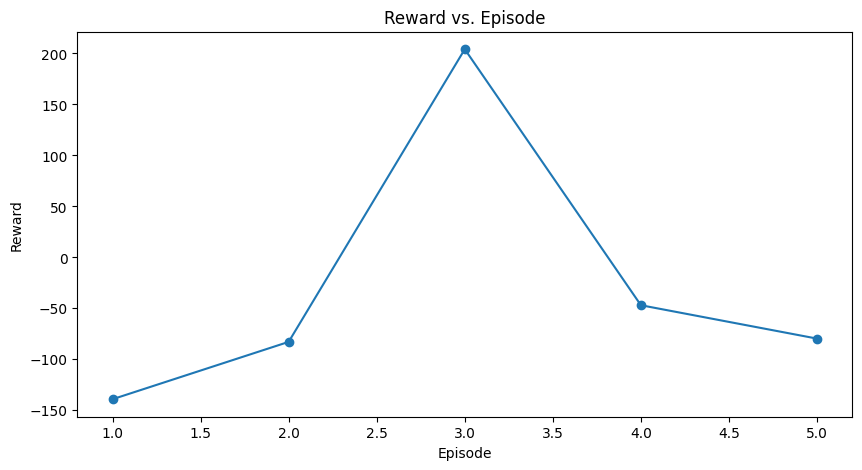

In [134]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  # 1 row, 2 columns, plot 1
plt.plot(episodes, rewards, marker='o')
plt.title('Reward vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

In [135]:
avgs = sum(rewards)/5
print (avgs)

-28.86996203581622
